# Residual move-out auto-tracking and seismic section flattening by using PWD. {-}

## 1. Before we start, we set the default setting and the plotting parameters. (Python version 3.7, OBSPY version 1.2.1 ) {-}

### 1.1 Import preliminary libraries, set the default setting, and import the dataset (synthetic section, NRM field). {-}

In [24]:
import scipy.ndimage
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy
from matplotlib import collections
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.style
import matplotlib as mpl
from scipy import interpolate
from scipy.signal import savgol_filter

#################################STYLE#############################

mpl.style.use('default')
mpl.rcParams['font.size'] = 6
mpl.rcParams['lines.linewidth'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = np.sqrt(0.5)
mpl.rcParams['scatter.marker'] = "v"

######################DEFINE PATH AND MAIN OBJECTS##############
#ip1 = _read_segy(r'./inputdata_withavo/3D_SYN_OG_SO190_313_41.sgy', headonly=True)        # synthetic seismic section
ip1 = _read_segy(r'./inputdata_withavo/3D_SYN_OG_SO190_313_BUNCH.sgy', headonly=True)     # synthetic seismic section
#ip1 = _read_segy(r'./inputdata_withavo/3D_SYN_OG_SO190_313_BUNCH_V5.sgy', headonly=True)     # synthetic seismic section

#ip2 = _read_segy(r'./inputdata_withavo/3D_DISPLACE_SO190_313_OPS.sgy', headonly=True)     # NRM displacement field. Segy sample interval: 2 m. Number of traces: 250.
ip2 = _read_segy(r'./inputdata_withavo/3D_DISPLACE_SO190_313_BUNCH.sgy', headonly=True)     # NRM displacement field. Segy sample interval: 2 m. Number of traces: 250.
#ip2 = _read_segy(r'./inputdata_withavo/3D_DISPLACE_SO190_313_BUNCH_V5.sgy', headonly=True)     # NRM displacement field. Segy sample interval: 2 m. Number of traces: 250.

#ip2 = _read_segy(r'./inputdata_withavo/3D_DISPLACE_DIP_SO190_313_.sgy', headonly=True)     # NRM displacement field. Segy sample interval: 2 m. Number of traces: 250.

trace_length = 2500      # we interpolate the synthetic seismic section and the NRM field ten times in order to avoid the aliasing in further calculation.
nrm_tracelength = 250    # 250 is the original number of traces in the NRM field.
dt = 2e-3
y = np.linspace(0.,trace_length,trace_length) 
multiplier_nrm = 0.5 * trace_length / nrm_tracelength  # the 0.5 multiplier here is due to NRM's 2m sample rate. 


ip1_stk = np.delete(np.stack(t.data for t in ip1.traces), 0 , 1) # the first row of the zero row is deleted
ip1_seis = scipy.signal.resample(ip1_stk,trace_length,axis=1).T  # resample the data ten times in depth domain.

new_index = np.arange(0,trace_length)
old_index = np.arange(0,nrm_tracelength) * trace_length / nrm_tracelength     
ip2_stk = np.delete(np.stack(t.data for t in ip2.traces), 0 , 1) 
fun_interp = interpolate.interp1d(old_index, ip2_stk, kind='linear', fill_value='extrapolate') # define the function to interpolate the NRM field ten times.
ip2_seis = multiplier_nrm * fun_interp(new_index).T


C:\Users\yxia\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### 1.2 Set up the optmization parameters for matplotlib sub plotting (annotation, label, title, text boxes, etc).  {-}

In [25]:
def fig_opt():

    ########################OFFSET_AXE_TWINY###################################
    ax1_off = ax1.twiny()      #TWIN THE X AXE As offsetdomain
    ax2_off = ax2.twiny()      #TWIN THE X AXE As offsetdomain
    ax3_off = ax3.twiny()      #TWIN THE X AXE As offsetdomain
    ax4_off = ax4.twiny()      #TWIN THE X AXE As offsetdomain

    oldticks = ax1.get_xticks()
    newticks = []
    
    for X in oldticks:
        newticks.append(X * 0.1)

    ax1_off.set_xticks(oldticks)
    ax1_off.set_xbound(ax1.get_xbound())
    ax1_off.set_xticklabels(newticks)

    ax2_off.set_xticks(oldticks)
    ax2_off.set_xbound(ax1.get_xbound())
    ax2_off.set_xticklabels(newticks)

    ax3_off.set_xticks(oldticks)
    ax3_off.set_xbound(ax1.get_xbound())
    ax3_off.set_xticklabels(newticks)

    ax4_off.set_xticks(oldticks)
    ax4_off.set_xbound(ax1.get_xbound())
    ax4_off.set_xticklabels(newticks)

    ax3_off.set_xticklabels([]) #set the twin axe lable to nothing
    ax4_off.set_xticklabels([]) #set the twin axe lable to nothing

    ax1.set_ylabel('Depth [km]')
    ax3.set_ylabel('Depth [km]')

    ax1_off.set_xlabel('Offset [km]')
    ax2_off.set_xlabel('Offset [km]')
    #ax3_off.set_xlabel('Offset [km]')
    #ax4_off.set_xlabel('Offset [km]')


    ax3.set_xlabel('Trace Number')
    ax4.set_xlabel('Trace Number')

    #################### Y axis MOD ''''''''''''''''''''''''''
    oldyticks = ax1.get_yticks()

    newyticks = []
    for X in oldyticks:
        newyticks.append(X * 0.001 * 0.2 + 3)

    ax1.set_yticks(oldyticks)
    ax1.set_ybound(ax1.get_ybound())
    ax1.set_yticklabels(newyticks)
    ax2.set_yticks(oldyticks)
    ax2.set_ybound(ax2.get_ybound())
    ax2.set_yticklabels(newyticks)
    ax3.set_yticks(oldyticks)
    ax3.set_ybound(ax3.get_ybound())
    ax3.set_yticklabels(newyticks)
    ax4.set_yticks(oldyticks)
    ax4.set_ybound(ax4.get_ybound())
    ax4.set_yticklabels(newyticks)

### 1.3 Set up the optmization parameters for matplotlib single plotting (annotation, label, title, text boxes, etc). {-}

In [26]:
def fig_opt_single(title_text, title_font_size):

    ########################OFFSET_AXE_TWINY###################################
    ax1_off = ax1.twiny()      #TWIN THE X AXE As offsetdomain

    oldticks = ax1.get_xticks()

    newticks = []
    for X in oldticks:
        newticks.append(X * 0.1)

    ax1_off.set_xticks(oldticks)
    ax1_off.set_xbound(ax1.get_xbound())
    ax1_off.set_xticklabels(newticks)

    ax1.set_ylabel('Depth [km]')

    ax1_off.set_xlabel('Offset [km]')
    ax1.set_xlabel('Trace Number')
    ax1.set_ylim(trace_length, 0)
    ax1.set_title(title_text, fontsize = title_font_size)

    #################### Y axis MOD ''''''''''''''''''''''''''
    oldyticks = ax1.get_yticks()

    newyticks = []
    for X in oldyticks:
        newyticks.append(X * 0.001 * 0.2 + 3)

    ax1.set_yticks(oldyticks)
    ax1.set_ybound(ax1.get_ybound())
    ax1.set_yticklabels(newyticks)

### 1.4 Define the function to plot the figure with "blue white red" palatte. {-}

In [27]:
############################## PLOT QC Color #############################
def plot_qc_bwr(input_data, axs_num, textbox, colorbar_textbox, output_name):
    
    vm = np.percentile(input_data, 100)
    #fig,(axs_num) = plt.subplots(1, sharey='all', sharex='all')
    
    disimage = axs_num.imshow(input_data, cmap="bwr", vmin=-vm, vmax=vm, aspect="auto")
    axs_num.set_xlim(-0.5,40.5)
    t3 = axs_num.text(0.03,0.93, textbox, transform=axs_num.transAxes)
    t3.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    
    cbaxes = fig.add_axes([0.92, 0.53, 0.015, 0.35]) 
    cb = plt.colorbar(disimage, cax = cbaxes, label=colorbar_textbox)
    plt.savefig(output_name, dpi=100)
    
    return 'QC color'

### 1.5 Define the function to plot the figure with wiggles. {-}

In [28]:
########################### PLOT WIGGLE QC ###############################
def plot_qc_wiggle(input_data, axs_num, text_box, output_name, trace_length):
    offsets = np.linspace(0,40,41,dtype=float)
    y = np.linspace(0.,trace_length - 1.,trace_length) 
    #fig,(axs_num) = plt.subplots(1, sharey='all', sharex='all')

    for offset in offsets:
        one_trace_2 = input_data[:,int(offset)]
    
        ampl_2 = offset + one_trace_2*0.00006
        axs_num.plot(ampl_2,y,'k-')
    
        axs_num.fill_betweenx(y,offset,ampl_2,where=(ampl_2>offset),color='k',linewidth=0.1)
        axs_num.set_ylim(trace_length,0)
        axs_num.set_xlim(-0.5,40.5)
    
    text_info = text_box  # print the parameter on the figure for testing.
    
    t3 = axs_num.text(0.03,0.93,text_info, transform=axs_num.transAxes)
    t3.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    plt.savefig(output_name, dpi=100)

    return 'wiggle plot exec'

## 2. RMO automatic calculation, seismic synthetic section flattening by using NRM displacement field. {-}

### 2.1 Plot the original synthetic section in wiggles.  {-}

Text(0.5, 0.01, 'Figure S1. Synthetic seismic section with bunch reflectors')

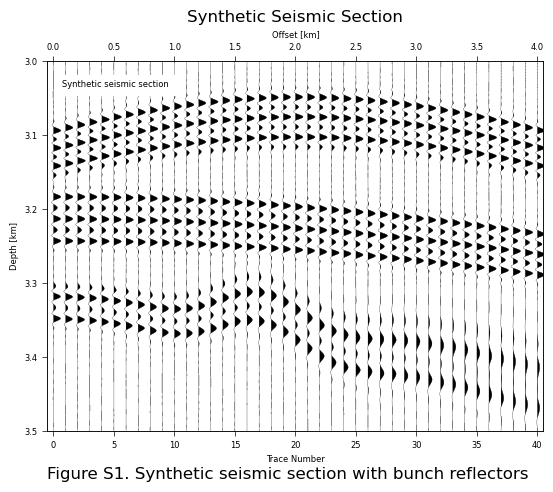

In [52]:
fig,(ax1) = plt.subplots(1, sharey='all', sharex='all')
plot_qc_wiggle(ip1_seis, ax1, 'Synthetic seismic section', 'Seismic_syn_origin.pdf', trace_length)
fig_opt_single('Synthetic Seismic Section', 12)

plt.figtext(0.5, 0.01, "Figure S1. Synthetic seismic section with bunch reflectors", wrap=True, horizontalalignment='center', fontsize=12)


### 2.2 Smooth the NRM field by using the Savitzky-Golay filter.  {-}

In [30]:
 def nrm_sg_smooth(length, poly):
    
    numberoftraces = np.arange(0,41)[ : : -1]    # it is an array of [41, 40, 39, 38, 37, 36 ........ 0]
    ip2_seis_smooth = np.zeros((trace_length,41), float)
    
    for trace in numberoftraces:
        
        ip2_seis_tmp = savgol_filter(ip2_seis[:,trace], length, poly, mode='nearest', axis = 0) 
        ip2_seis_smooth[:,trace] = ip2_seis_tmp
    return ip2_seis_smooth

length = 401 # define the window length of the S-G filter.
poly = 6     # define the polynominal order of the S-G filter.
ip2_seis_smooth = nrm_sg_smooth(length, poly)

Text(0.5, 0.01, 'Figure S2. NRM displacement field calculated from Figure S1')

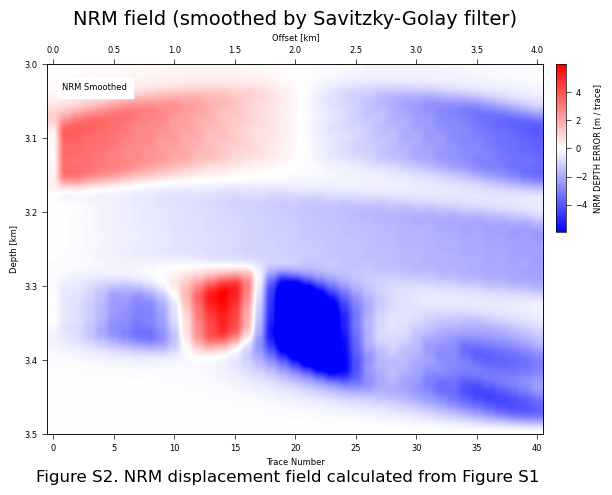

In [53]:
fig,(ax1) = plt.subplots(1, sharey='all', sharex='all')
plot_qc_bwr(ip2_seis_smooth / multiplier_nrm, ax1, 'NRM Smoothed','NRM DEPTH ERROR [m / trace]', 'NRM_smooth.pdf')
fig_opt_single('NRM field (smoothed by Savitzky-Golay filter)', 14)
plt.figtext(0.5, 0.01, "Figure S2. NRM displacement field calculated from Figure S1", wrap=True, horizontalalignment='center', fontsize=12)


### 2.3 Flatten the seismic trace by using the relative NRM field (approach 1). {-}

### As the raw NRM field represents the relative depth shift from any trace to its previous neighbouring trace, the whole seismic section could be flattened and aligned to the first trace. A simple math fomula could be expressed as below to flatten the seismic section {-}

$$
g_{(i,j)}=\begin{cases}
 & \text f_{(i,j)}+ h_{(i,j)}, \ \ \  \ \ { if } \ \  i=1 \\ 
 & \text g_{(i-1,j)} + h_{(i,j)}, \ \ { if } \ \ i>1 
\end{cases}
$$

### where $g_{(i,j)}$ represents the flattened seismic section, $f_{(i,j)}$ represents the input seismic section, and the $h_{(i,j)}$ represents the NRM field. The $i$ represents the trace number, and the $j$ represents the depth of the seismic sample. The script function below shows how to implete the equations above into a Python script.  {-}

In [32]:
def flat_syn_by_relative_nrm(dataset_toflat, nrm_input):                          # define your input data. 

    some_traces = np.empty((trace_length, 0), float)  # define an empty array in here
    maxi_trace = np.arange(0,41)             # define the maximum trace number in here.
    
    for trace_index in maxi_trace:            # start to loop to shift each trace
    
        ns = np.arange(0,trace_index + 1)[ : :-1]       # define the maximum number of correcting, which is the exact number of the trace number
        seis_trace_2d = dataset_toflat[:,trace_index][:, np.newaxis] # you select the trace, and add a dimention in here for the later interpolation. now it is 2d. 
        
        for n in ns:                                             # now you start to shift once for a trace. 
            nrm_dis_trace_2d = nrm_input[:,n][:, np.newaxis]       # now you select the NRM trace before starting the flattening
            seq_2d = np.arange(1, trace_length + 1, dtype=float)[:, np.newaxis]  # now you define an arraw as a index of the trace
            correction_2d = nrm_dis_trace_2d * 1 + seq_2d         # now you shift the index by the NRM field
            correction_1d = np.squeeze(correction_2d)       # you decrease the dimension in here because the interpolation works on 1d array
            seis_trace_1d = np.squeeze(seis_trace_2d)       # you decrease the dimension in here because the interpolation works on 1d array
            seq_1d = np.squeeze(seq_2d)                     # you decrase the dimention. 
        
            fun_interp = interpolate.interp1d(correction_1d, seis_trace_1d,kind='linear', fill_value='extrapolate')     # now you define the interpolation to shift the samples (500 samples)
            seis_trace_2d = fun_interp(seq_1d)[:, np.newaxis]    # now you subtract the new traces which is shifted, and incrase the dimenion to 2d again. 
        
        some_traces = np.append(some_traces, seis_trace_2d, axis=1) # now you put a finished flattened trace into your destination array.
    
    return some_traces    # return the whole gather (41 traces)

flat_syn_rel =  flat_syn_by_relative_nrm(ip1_seis, ip2_seis_smooth)

Text(0.5, 0.01, 'Figure S3. Corrected seismic section by using relative scheme with NRM displacement field (Fig. S2)')

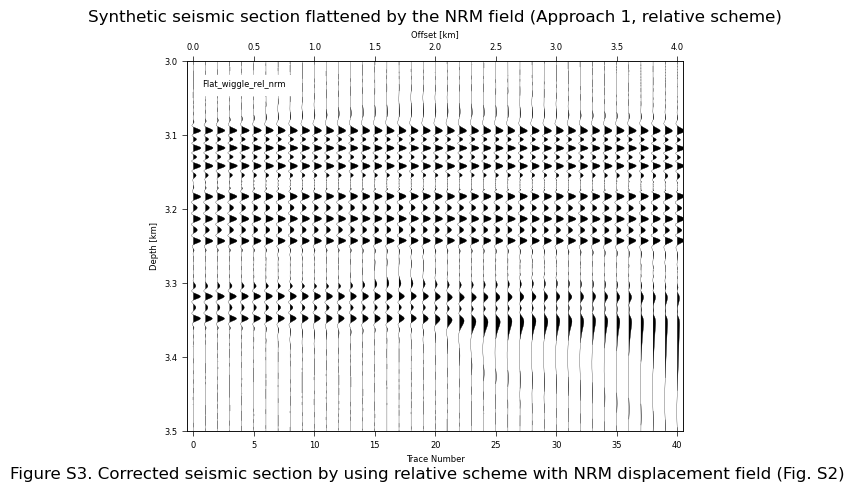

In [54]:
fig,(ax1) = plt.subplots(1, sharey='all', sharex='all')
plot_qc_wiggle(flat_syn_rel, ax1, 'Flat_wiggle_rel_nrm', 'Flat_wiggle_rel_nrm.pdf', trace_length)
fig_opt_single('Synthetic seismic section flattened by the NRM field (Approach 1, relative scheme)', 12)

plt.figtext(0.5, 0.01, "Figure S3. Corrected seismic section by using relative scheme with NRM displacement field (Fig. S2)", wrap=True, horizontalalignment='center', fontsize=12)


### 2.4 Calculate the absolute NRM field. (This is need for the alternative absolute flattening approach (approach 2), beside the recursive relative NRM RMO tracking (2.3).) The equation to calculate the absolute NRM field (always to the first trace) could be expressed as a recursive calcualtion {-}

$$
\begin{split}  
&k_{(i,j)} \\ 
&=h_{(i,j)} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \, , if \ \ i = 1 \\
&=h_{(i,j)} + h_{(i-1, j+h_{(i,j)})} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ ,  if \ \ i = 2 \\
&=h_{(i,j)} + h_{(i-1, j+h_{(i,j)})} + h_{(i-2, j + h_{(i,j)} + h_{(i-1, j + h_{(i,j)})})} \ , if \ \ i = 3 \\
&............\\
&............\\
&............\\
\end{split}
$$

### where $h_{(i,j)}$ represents the origional (relative) NRM field, $k_{(i,j)}$ represents the the absolute NRM field, in which each sample represents the depth shift compared always to the first trace. The script function below shows how to implete the equations above into a Python script.  {-}

In [34]:
def absolute_nrm_calc(input_data):
    
    some_traces = np.zeros((trace_length, 41), float)  # define an empty array in here, all elements are zeros.
    
    number_of_traces = np.arange(0, 41)
    #trace_num = 40  # (40 39 ... 0)
    for trace_num in number_of_traces:
        
        sample_length = np.arange(0, trace_length)
        #sample_num = 130  # (0 1 2 ... 499)
        
        for sample_num in sample_length:
            
            first_depth = sample_num  # the first sample
            new_depth = sample_num    # the sample that will be updated all the time
            
            retrack_iter = np.arange(0, 1 + trace_num)[ : : -1]  # define the retrack array '1 + trace_num' is the number of element.
            
            for iteration in retrack_iter:                       # execuate the job from 40 39 38..... 0.
                if new_depth >= 2499:
                    new_depth = 2499
                else:
                    new_depth = new_depth
                new_depth = new_depth + input_data[int(new_depth),iteration]    # iteratively update the new sample untile reach the first trace.
            
            final_depth = new_depth                # now you get your final depth in the final iternation, which is the first nrm trace correction.
            absolute_nrm_sample = final_depth - float(first_depth) # this is the absolute nrm value for this sample, in a trace.
            some_traces[sample_num,trace_num] = absolute_nrm_sample
    return some_traces

absolute_nrm = absolute_nrm_calc(ip2_seis_smooth)    # run this to get the absolute NRM array


Text(0.5, 0.01, 'Figure S4. Absolute NRM displacement field calculated from the raw (relative) NRM field (Fig. S2)')

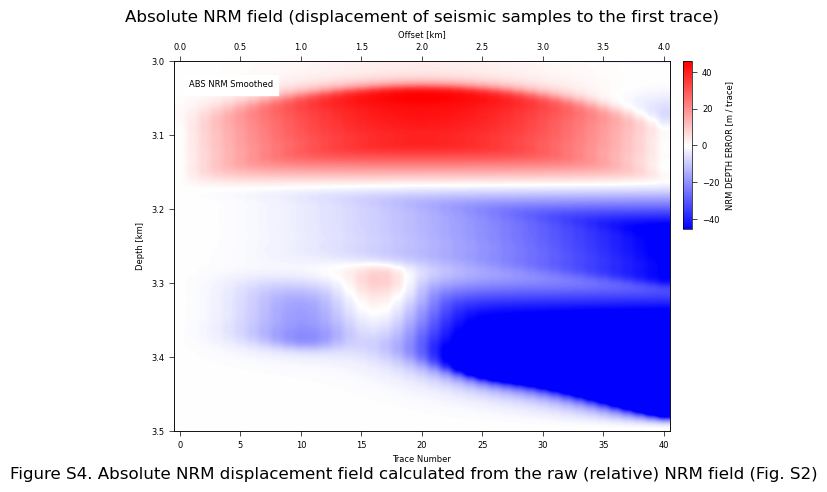

In [55]:
fig,(ax1) = plt.subplots(1, sharey='all', sharex='all')
plot_qc_bwr(absolute_nrm * 0.2, ax1, 'ABS NRM Smoothed','NRM DEPTH ERROR [m / trace]', 'ABS_NRM_smooth.pdf')
fig_opt_single('Absolute NRM field (displacement of seismic samples to the first trace)', 12)

plt.figtext(0.5, 0.01, "Figure S4. Absolute NRM displacement field calculated from the raw (relative) NRM field (Fig. S2)", wrap=True, horizontalalignment='center', fontsize=12)


### 2.5 Flatten the seismic section by applying the absolute NRM field.  {-}

In [36]:
def flat_syn_by_absolute_nrm():
    
    old_index_arr = np.zeros((trace_length,41), float)
    single_index_list = np.arange(0,trace_length)
    
    iterations = np.arange(0,41)
    
    for iteration in iterations:
        old_index_arr[:,iteration] = single_index_list
        
    old_index = old_index_arr
    new_index = old_index + absolute_nrm
    
    flat_section = np.zeros((trace_length,41), float)
    
    number_of_traces = np.arange(0,41)
    
    for each_trace in number_of_traces:
        
        fun_interp = interpolate.interp1d(new_index[:,each_trace], ip1_seis[:,each_trace], kind='linear', fill_value='extrapolate')
        
        flat_trace = fun_interp(old_index[:,each_trace])
        
        flat_section[:,each_trace] = flat_trace
        
    return flat_section
    
###################################################################

flat_syn_abs = flat_syn_by_absolute_nrm()

Text(0.5, 0.01, 'Figure S5. Corrected seismic section by using absolute scheme with absolute NRM displacement field (Fig. S4)')

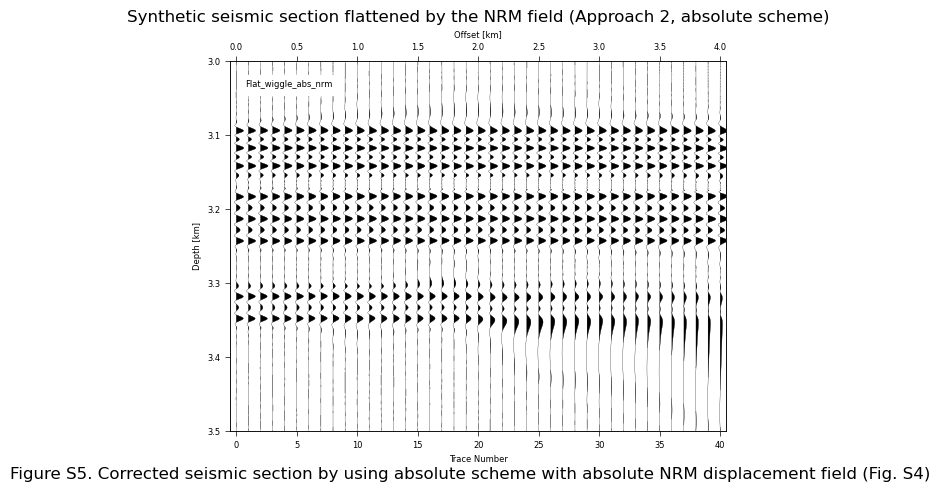

In [56]:
fig,(ax1) = plt.subplots(1, sharey='all', sharex='all')
plot_qc_wiggle(flat_syn_abs, ax1, 'Flat_wiggle_abs_nrm', 'Flat_wiggle_abs_nrm.pdf', trace_length)
fig_opt_single('Synthetic seismic section flattened by the NRM field (Approach 2, absolute scheme)', 12)

plt.figtext(0.5, 0.01, "Figure S5. Corrected seismic section by using absolute scheme with absolute NRM displacement field (Fig. S4)", wrap=True, horizontalalignment='center', fontsize=12)


### 2.6 Semblance calcution{-}

### With the help of the flattened seismic section, one could retreive the starting depth of the RMO tracking by scanning the semblance of the seismic depth slice. The script below calculate the semblance by using the equation {-}

$$ s_{(j)} = (\sum_{i=1}^{n} f_{(i,j)})^{2} / \sum_{i=1}^{n} f_{(i,j)}^{2} /n $$

### where $n$ is the maximum number of traces, $s_{(j)}$ represents the semblance value, $f_{(i,j)}$ represent the seismic section. The depth of the four semblance peaks in the figure below is used as the starting depth for later automatic RMO tracking (2.7). The script function below shows how to implete the equation above into a Python script.  {-}

In [38]:
def semblance_calc(input_seis):

    number_of_trace = 41
    number_of_index = np.arange(0, trace_length)
    all_semblance = np.zeros(trace_length)
    
    for index_num in number_of_index:
        
        cut_seis = input_seis[:,:number_of_trace]
        slice_syn = cut_seis[index_num,:]
        each_semblance =  sum(slice_syn) * sum(slice_syn)  / (sum(i*i for i in slice_syn)) / number_of_trace
        all_semblance[index_num] = each_semblance
        all_semblance_smooth = savgol_filter(all_semblance, 401, 6, mode='nearest', axis = 0)
        all_semblance_smooth[all_semblance_smooth < 0] = 0
        
    #return all_semblance_smooth
    return all_semblance, all_semblance_smooth, cut_seis

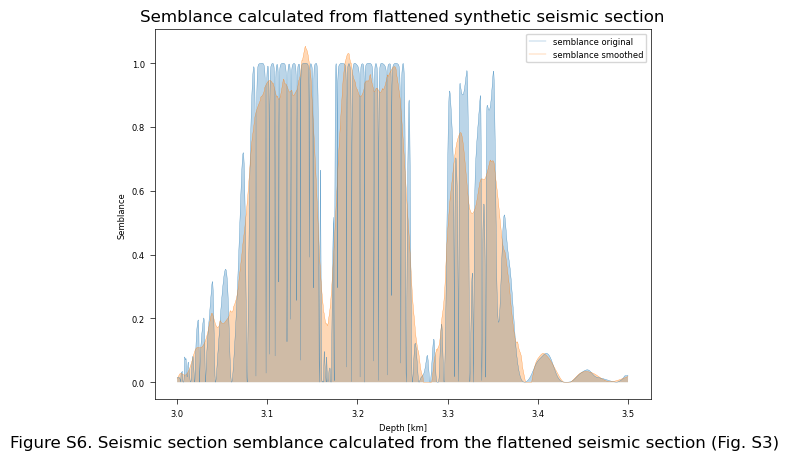

In [58]:
(all_semb, all_semb_smooth, cut_seis) = semblance_calc(flat_syn_rel)
ones_semb = np.linspace(3,3.5,trace_length)

plt.plot(ones_semb, all_semb, label='semblance original')
plt.fill_between(ones_semb, all_semb, 0, alpha=0.30)
plt.plot(ones_semb, all_semb_smooth, label='semblance smoothed')
plt.fill_between(ones_semb, all_semb_smooth, 0, alpha=0.30)
plt.xlabel('Depth [km]')
plt.ylabel('Semblance')
plt.title('Semblance calculated from flattened synthetic seismic section', fontsize=12)

plt.figtext(0.5, 0.01, "Figure S6. Seismic section semblance calculated from the flattened seismic section (Fig. S3)", wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()
plt.show()

#plt.imshow(cut_seis, interpolation='none', aspect=0.01 )



In [40]:
def plot_semblance(location_para):
    semb_axs = fig.add_axes(location_para)
    semb_axs.fill_between(all_semb_smooth, ones_semb, 0, alpha=0.30)
    semb_axs.plot(all_semb_smooth, ones_semb)
    
    x_values = np.ones((trace_length,1), float) * 0.5                            # disable this if no bunch grid pick
    semb_axs.plot(x_values, ones_semb,  linestyle="--")                          # disable this if no bunch grid pick
    
    counters = np.arange(0,500,12) # pure grid based picking, start 0, end 480, interval 10 meters.
    new_counters = counters                  # define the new counters to do the 
    #print(counters)
    
    for counter in counters:
        if all_semb_smooth[counter*5] < 0.5:
            new_counters = new_counters[new_counters != counter]
    #print(counters)
    #print(new_counters)
            
    new2_counters = new_counters * 0.001 + 3
    x1_values = np.ones(new2_counters.size, float) * 0.5
    
    print(new_counters)
    print(x1_values)
    ##########################################################
    counters = np.arange(0,x1_values.size)   # plot the scatter marker in this block
    print(counters)
    plt.gca().set_prop_cycle(None)    # reset the color cycle in here.

    for counter in counters:                                                     # disable this if no bunch grid grid pick
            semb_axs.scatter(x1_values[counter],new2_counters[counter])          # disable this if no bunch grid grid pick
    #########################################################

    #semb_axs.scatter(x1_values,new2_counters)
    
    semb_axs.set_ylim(3.5,3.0)
    semb_axs.set_xlim(-0.2,1)
    semb_axs.set(xlabel='Semblance', ylabel='Depth [km]')

    return

[ 84  96 108 120 132 144 156 180 192 204 216 228 240 252 312 324 336 348]
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


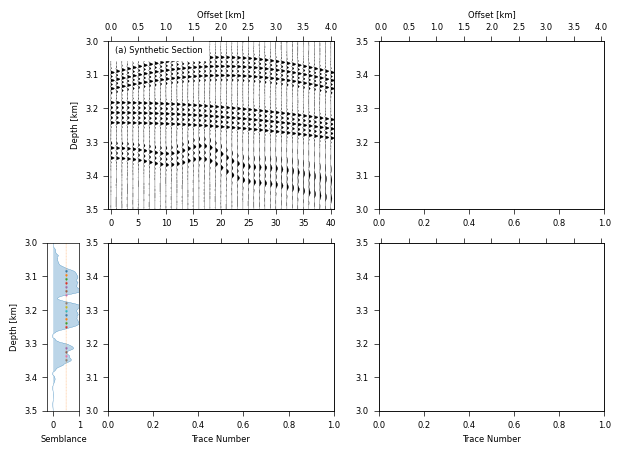

In [41]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
#plot_qc_wiggle(flat_syn_rel, ax3, 'Flat_wiggle_rel_nrm', 'Flat_wiggle_rel_nrm.pdf', trace_length)
plot_qc_wiggle(ip1_seis, ax1, '(a) Synthetic Section', 'Flat_wiggle_abs_nrm.pdf', trace_length)

plot_semblance([0.03, 0.11, 0.05, 0.35])
fig_opt()
plt.savefig('Figure222.pdf', dpi=300, format='pdf', bbox_inches='tight')

### The depth of the flattened synthetic seismic semblance peak values (Figure above) represent the approximated depth of the seismic events' depth (Table below). However, the semblance peak value and its depth cannot provide the seismic events' exact starting depth for RMO tracking, since the wavelet is consist of a series of samples which express the same value of semblance (~ 1.0). In real situations, the exact starting depth of the RMO tracking should be searched within a depth window based on the semblance peak depth in the first trace of the seismic section. In this synthetic test script, we manually read the peak amplitude of the seismic events from the first trace of the original synthetic seismic section for simplification. {-}

| Event No. | Seismic peak amplitude depth (km) | Semblance peak depth (original) (km) | Semblance peak depth (smoothed) (km) |
| --- | --- | --- | --- |
| Event 1. (Blue) | 3.126 | 3.120 | 3.124 | 
| Event 2. (Orange) | 3.204 | 3.198 | 3.194 |
| Event 3. (Green) | 3.254 | 3.261 | 3.259 |
| Event 4. (Red) | 3.364 | 3.366 | 3.359 |

### 2.7 Now we define the function to calculate the RMO based on the NRM field and the formula  {-}

$$
x_{(i)}=\begin{cases}
 & \text x_{(0)}, \ \ { if } \ \  i=1 \\ 
 & \text x_{(i-1)} + h_{(i,x_{(i-1)})}, \ \ { if } \ \ i>1 
\end{cases}
$$

### where  $x_{(i)}$ represents the depth error sequence over the section, $x_{(0)}$ is predefined start picking depth, and $h$ represend the NRM field. Please note that the $x_{(0)}$ should be predefined (e.g., from the semblance peak values above). The script function below shows how to implete the equations a above into a Python script.  {-}

In [42]:
def rmo_calc(start_time):
    matrix = ip2_seis.T * -1.00

    #####################first hori#############################
    ns = np.arange(0,41)
    starttime = start_time * multiplier_nrm
    # read from the segy of the synthetic that the peak amplitude of the first event in the first trace is the sample 126
    overall = np.array([])
    #y3 = np.arange(0,41)

    for n in ns:
        #starttime = np.squeeze(starttime) 
        disvalue = matrix[n, int(starttime)]
        starttime = disvalue + starttime
        overall = np.append (overall, [starttime])
        
    return overall

    #ax4.scatter(y3,overall,s=size,label=label_name)

### Now we define the function to plot to plot the RMO pickers. {-}

In [69]:
def plot_picker_nrm_autogrid(ax4, size, semb_thres, text_box):
    y3 = np.arange(0,41)

    counters = np.arange(0,500,12) # pure grid based picking, start 0, end 480, interval 10 meters.
    new_counters = counters                  # define the new counters to do the 
    #print(counters)
    
    for counter in counters:
        if all_semb_smooth[counter*5] < semb_thres:
            new_counters = new_counters[new_counters != counter]
    #print(counters)
    #print(new_counters)
        
    
    
    for counter in new_counters:
        pickers = rmo_calc(counter)
        ax4.scatter(y3,pickers,s=size,label='RMO_Picker')
    
    ax4.set_ylim(2500,0)
    ax4.set_xlim(-0.5,40.5)

    #ax4.legend(fontsize=5, loc='lower left',frameon=False, ncol=2)

    t4 = ax4.text(0.03,0.93,text_box, transform=ax4.transAxes)
    t4.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    #print(counters)


def plot_picker_nrm_predef(ax4, size, text_box):
    y3 = np.arange(0,41)
    
    depth0_array = np.array([96, 96+12*1,96+12*2,96+12*3,96+12*4,96+12*5, ...and
                             186, 186+14*1,186+14*2,186+14*3,186+14*4, ...and
                             306, 306+14*1,306+14*2,306+14*3,])      # this is the bunch synthetic
    
    #depth0_array = np.array([124, 204, 254, 364]) # this is for the four lines synthetic


    for depth_0 in depth0_array:
        pickers = rmo_calc(depth_0)
        ax4.scatter(y3,pickers,s=size,label='RMO_Picker')
    
    ax4.set_ylim(2500,0)
    ax4.set_xlim(-0.5,40.5)

    #ax4.legend(fontsize=5, loc='lower left',frameon=False, ncol=2)

    t4 = ax4.text(0.03,0.93,text_box, transform=ax4.transAxes)
    t4.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
    return

### Now we excute the function above to plot the RMO. {-}

Text(0.5, 0.01, 'Figure. S7 Residual Move-out (RMO) auto-tracked by using relative scheme')

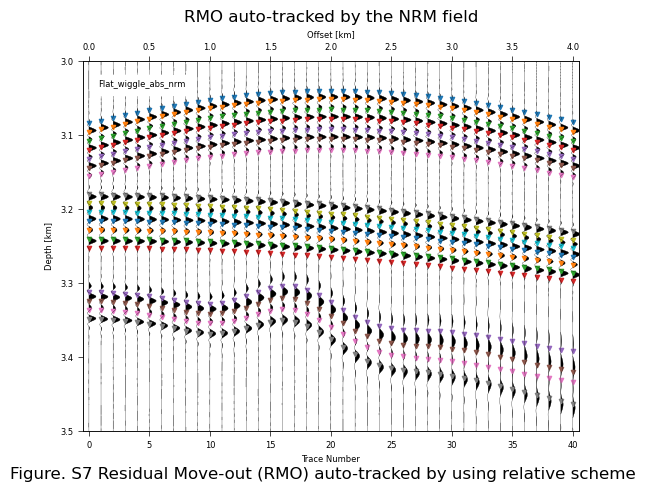

In [70]:
fig,(ax1) = plt.subplots(1, sharey='all', sharex='all')
plot_qc_wiggle(ip1_seis, ax1, 'Flat_wiggle_abs_nrm', 'Flat_wiggle_abs_nrm.pdf', trace_length)
plot_picker_nrm_autogrid(ax1, 9, 0.5, 'Flat_wiggle_abs_nrm') # the variable defines the size of the marker (picker). 
#plot_picker_nrm_predef(ax1, 9, 'track') # the variable defines the size of the marker (picker). 

fig_opt_single('RMO auto-tracked by the NRM field', 12)

plt.figtext(0.5, 0.01, "Figure. S7 Residual Move-out (RMO) auto-tracked by using relative scheme", wrap=True, horizontalalignment='center', fontsize=12)


## 3. Now we plot the Figure 2 in the manuscript, by executing previous functions. {-}


[ 84  96 108 120 132 144 156 180 192 204 216 228 240 252 312 324 336 348]
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


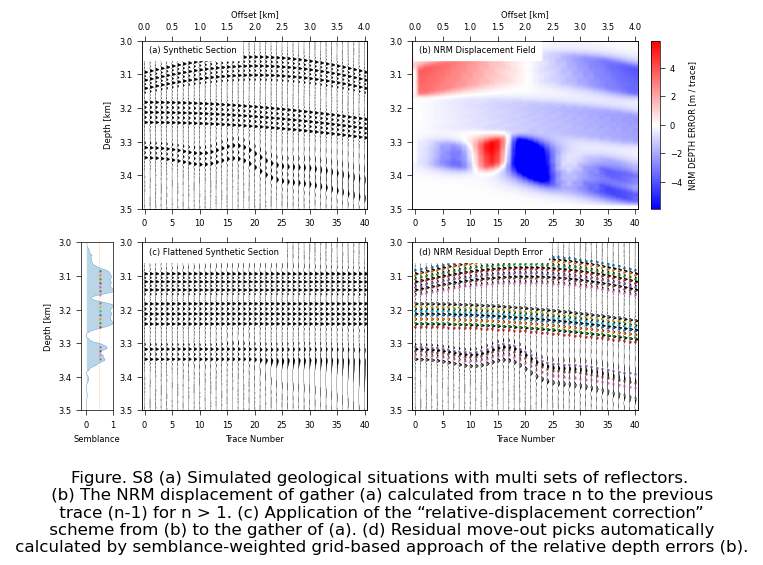

In [67]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
#plot_qc_wiggle(flat_syn_rel, ax3, 'Flat_wiggle_rel_nrm', 'Flat_wiggle_rel_nrm.pdf', trace_length)
plot_qc_wiggle(flat_syn_rel, ax3, '(c) Flattened Synthetic Section', 'Flat_wiggle_abs_nrm.pdf', trace_length)
plot_qc_wiggle(ip1_seis, ax1, '(a) Synthetic Section', 'Flat_wiggle_abs_nrm.pdf', trace_length)

plot_qc_bwr(ip2_seis * 0.2, ax2, '(b) NRM Displacement Field','NRM DEPTH ERROR [m / trace]', 'NRM_smooth.pdf')
plot_qc_wiggle(ip1_seis, ax4, ' ', 'Flat_wiggle_abs_nrm.pdf', trace_length)
plot_picker_nrm_autogrid(ax4, 0.8, 0.5, '(d) NRM Residual Depth Error') # the variable defines the size of the marker (picker). 
#plot_picker_nrm_predef(ax4, 1, '(d) NRM Residual Depth Error') # the variable defines the size of the marker (picker). 
plot_semblance([0.03, 0.11, 0.05, 0.35])
fig_opt()

plt.figtext(0.5, -0.18, "Figure. S8 (a) Simulated geological situations with multi sets of reflectors. \n (b) The NRM displacement of gather (a) calculated from trace n to the previous \n trace (n-1) for n > 1. (c) Application of the “relative-displacement correction” \n scheme from (b) to the gather of (a). (d) Residual move-out picks automatically \n calculated by semblance-weighted grid-based approach of the relative depth errors (b). ", wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig('Figure2.png', dpi=300, bbox_inches='tight')


# ## 4. Now we plot the comparision amoung the predefined depth_0, pure grid based picking, and semblance weighted grid based picking. {-}

[ 84  96 108 120 132 144 156 180 192 204 216 228 240 252 312 324 336 348]
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


Text(0.5, -0.05, 'Figure. S9 (a) RMO auto tracking by using pre-defined depth_0 read from near offset trace, (b) RMO tracking by \n using pure grid-based tracking scheme, (c) RMO picking from semblance-weighted grid-picking scheme')

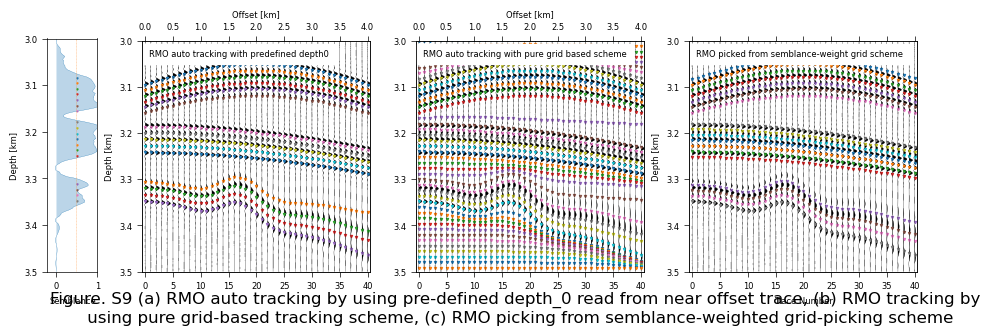

In [72]:
fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

plot_qc_wiggle(ip1_seis, ax1, ' ', '1.pdf', trace_length)
plot_picker_nrm_predef(ax1, 2, 'RMO auto tracking with predefined depth0')

plot_qc_wiggle(ip1_seis, ax2, ' ', '2.pdf', trace_length)
plot_picker_nrm_autogrid(ax2, 2, 0.0, 'RMO auto tracking with pure grid based scheme')
 
plot_qc_wiggle(ip1_seis, ax3, ' ', '3', trace_length)
plot_picker_nrm_autogrid(ax3, 2, 0.5, 'RMO picked from semblance-weight grid scheme') 
plot_semblance([0.03, 0.11, 0.05, 0.777])
fig_opt()
plt.savefig('Figure_3methods.png', dpi=300, bbox_inches='tight')

plt.figtext(0.5, -0.1, "Figure. S9 (a) RMO auto tracking by using pre-defined depth_0 read from near offset trace, (b) RMO tracking by \n using pure grid-based tracking scheme, (c) RMO picking from semblance-weighted grid-picking scheme", wrap=True, horizontalalignment='center', fontsize=12)


# End of the iPython Notebook {-}